In [1]:
from new_stations import *
from time_series_model import *

In [2]:
data, weather = load_data()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [3]:
data = feature_addition(data)

In [4]:
sf = model_city(data,1)

In [5]:
def month_sep(df, year, month):
    cdf = df[(df.year == year) & (df.month == month)]
    ndf = df[(df.year == year) & (df.month == (month-1))]
    return cdf, ndf

In [6]:
cdf, ndf = month_sep(sf, 2017, 12)

In [7]:
ps = new_stn_coords(cdf, ndf)

In [8]:
ps

[209.0, 50.0, 314.0]

In [9]:
neighbors = knn_proposed_stn(cdf, ndf, ps)

In [10]:
neighbors

{209: [28, 23, 24], 50: [48, 49, 81], 314: [130, 126, 116]}

In [11]:
qtr = days_for_ts(sf, cdf)

/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'] = 1
/Users/michellehoang/galvanize/Capstone_Project/time_series_model.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tsdf['days'][tsdf.month == mon] = tsdf.day * mult
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:8672: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_i

In [12]:
qtr

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_share_for_all_trip,day_of_week,date,year,month,day,hour,malfunction,age,days
2239215,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.2450,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,...,NaN,6,2017-12-31,2017,12,31,16,False,32.0,93
2239216,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.6170,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,...,NaN,6,2017-12-31,2017,12,31,15,False,54.0,93
2239218,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,...,NaN,6,2017-12-31,2017,12,31,17,False,NaN,93
2239220,9226,2017-12-31 22:51:00.918,2018-01-01 01:24:47.1660,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,-122.395282,30.0,San Francisco Caltrain (Townsend St at 4th St),37.776598,...,NaN,6,2017-12-31,2017,12,31,22,False,NaN,93
2239222,4334,2017-12-31 23:46:37.196,2018-01-01 00:58:51.2110,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,...,NaN,6,2017-12-31,2017,12,31,23,False,NaN,93
2239223,4150,2017-12-31 23:37:07.548,2018-01-01 00:46:18.3080,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,...,NaN,6,2017-12-31,2017,12,31,23,False,NaN,93
2239224,4238,2017-12-31 23:35:38.145,2018-01-01 00:46:17.0530,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,-122.399051,20.0,Mechanics Monument Plaza (Market St at Bush St),37.791300,...,NaN,6,2017-12-31,2017,12,31,23,False,NaN,93
2239225,3292,2017-12-31 23:46:32.403,2018-01-01 00:41:24.6050,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,22.0,Howard St at Beale St,37.789756,...,NaN,6,2017-12-31,2017,12,31,23,False,NaN,93
2239226,3177,2017-12-31 23:48:11.757,2018-01-01 00:41:09.5810,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,22.0,Howard St at Beale St,37.789756,...,NaN,6,2017-12-31,2017,12,31,23,False,NaN,93
2239227,2183,2017-12-31 23:52:55.581,2018-01-01 00:29:18.7430,67.0,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,24.0,Spear St at Folsom St,37.789677,...,NaN,6,2017-12-31,2017,12,31,23,False,29.0,93


In [46]:
def plt_stn():
    row_sze = len(neighbors)
    col_sze = len(next(iter(neighbors.values())))
    rnge = row_sze*col_sze
    fig = plt.figure(figsize=(10,10))
    graph = 1
    for k, v in neighbors.items():
        num = 1
        for s_id in v:
            plt.subplot(rnge,1,graph)
            plt.subplots_adjust(top=10, bottom =5)
            plt.xlabel("days")
            plt.ylabel("trips per day")
            plt.title("This is station {}, and it is neighbor #{} for station {}".format(s_id, num, k))
            ts = days_count(qtr, s_id)
            plt.plot(ts[:,0],ts[:,1])
            num+=1
            graph+=1

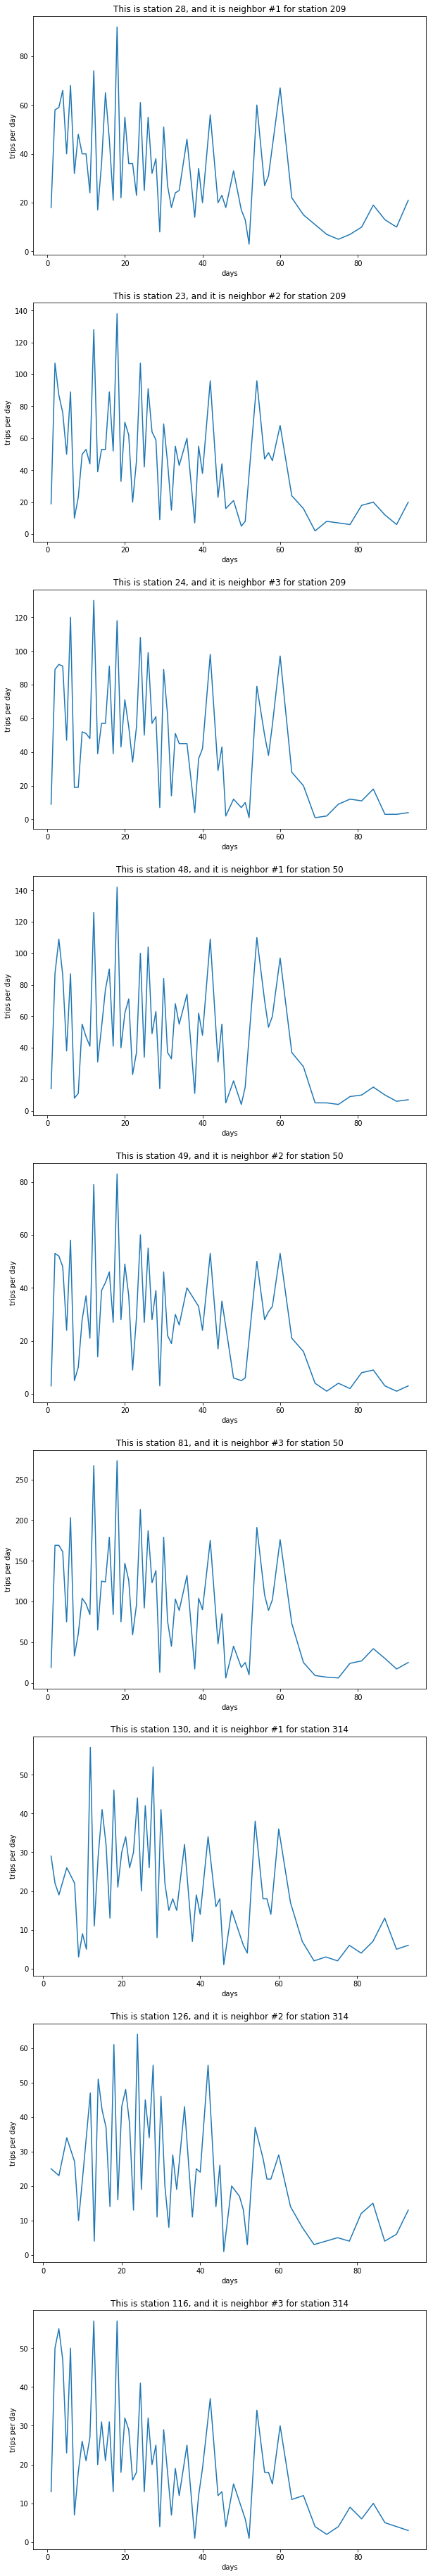

In [47]:
plt_stn()